In [1]:
####################引入头文件
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [2]:
####################常数和超参数
eps = 0.0000000005#浮点数取等计算误差允许范围5 * 10^(-10)
cutlinelimit = 0.6#切割线最后取新点设定阈值
linesize = 2#画图线条宽度
pointsize = 20#画图黄点大小

In [3]:
####################返回1和2点之间的距离
def distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
####################返回以1为角点的12,13两条线段成的角度
def degree(x1, y1, x2, y2, x3, y3):
    cos = ((x3 - x1) * (x2 - x1) + (y3 - y1) * (y2 - y1)) / distance(x1, y1, x2, y2) / distance(x1, y1, x3, y3)
    if abs(cos - 1) < eps:
        return 0
    elif abs(cos + 1) < eps:
        return math.acos(-1)
    else:
        return math.acos(cos)
####################判断一个内部永远在线段右侧（顺时针旋转）的多边形以1为角点的12,13两条线段成的内角度（与degree不同的是这个角可以>=π）
def truedegree(x1, y1, x2, y2, x3, y3):
    i = degree(x1, y1, x2, y2, x3, y3)
    if cross(x1, y1, x2, y2, x3, y3) < 0:
        i = 2 * math.pi - i
    return i
####################判断两条直线是否平行
def parallel(x1, y1, x2, y2, x3, y3, x4, y4):
    return abs((y4 - y3) * (x2 - x1) - (y2 - y1) * (x4 - x3)) < eps
####################判断两条平行线是否重合
def same(x1, y1, x2, y2, x3, y3, x4, y4):
    return abs((y3 - y1) * (x2 - x1) - (y2 - y1) * (x3 - x1)) < eps
####################返回以1为共同点的叉积
def cross(x1, y1, x2, y2, x3, y3):
    xd1 = x2 - x1
    yd1 = y2 - y1
    xd2 = x3 - x1
    yd2 = y3 - y1
    return xd1 * yd2 - xd2 * yd1
####################判断两条线断是否相交
def segment(x1, y1, x2, y2, x3, y3, x4, y4):
    #矩形判定
    if(max(x1, x2) - min(x3, x4) >= -eps#矩形1最右端大于矩形2最左端
    and max(x3, x4) - min(x1, x2) >= -eps#矩形2最右端大于矩形1最左端
    and max(y1, y2) - min(y3, y4) >= -eps#矩形1最高端大于矩形2最低端
    and max(y3, y4) - min(y1, y2) >= -eps):#矩形2最高端大于矩形1最低端
        if (cross(x1, y1, x2, y2, x3, y3) * cross(x1, y1, x2, y2, x4, y4) < eps and cross(x3, y3, x4, y4, x1, y1) * cross(x3, y3, x4, y4, x2, y2) < eps):
            d = 1#相交
        else:
            d = 0#不相交
    else:
        d = 0#不相交
    return d
####################判断一个点(x1, y1)是否在一条线段内(x2, y2, x3, y3)
def segmentpl(x1, y1, x2, y2, x3, y3):
    if x1 - min(x2, x3) > -eps and x1 - max(x2, x3) < eps and y1 - min(y2, y3) > -eps and y1 - max(y2, y3) < eps:
        if abs(cross(x2, y2, x1, y1, x3, y3)) < eps:
            return 1#在线上
        else:
            return 0#不在线上
    else:
        return 0#不在线上
####################判断一个点是否在一个n边形内
#nvert是多边形的顶点个数
#vertx是多边形顶点的x值的列表
#verty是多边形顶点的y值的列表
#(testx, testy)是检测点坐标
def pnpoly(nvert, vertx, verty, testx, testy):
    j = nvert - 1
    result = 0
    for i in range(nvert):
        if verty[j] == verty[i]:
            j = i
            continue
        x = (vertx[j] - vertx[i]) * (testy - verty[i]) / (verty[j] - verty[i]) + vertx[i]
        if ((verty[i] > testy) != (verty[j] > testy)) and (testx < x):
            result = 1 - result#点在多变形内，返回True
        j = i
    return result

In [4]:
####################将输入的两个域连接起来，此段负责返回分割线两段的点和itamax供选择
def findconnection(boundary, seed, flag):
    itamax = -114514
    number0 = 0
    number1 = 0
    for j in range(len(seed[0][0])):
        for k in range(len(seed[0][1])):
            x0 = seed[0][0][j]
            y0 = seed[1][0][j]
            x1 = seed[0][1][k]
            y1 = seed[1][1][k]
            x0l = seed[0][0][(j - 1) % len(seed[0][0])]
            y0l = seed[1][0][(j - 1) % len(seed[0][0])]
            x0r = seed[0][0][(j + 1) % len(seed[0][0])]
            y0r = seed[1][0][(j + 1) % len(seed[0][0])]
            x1l = seed[0][1][(k - 1) % len(seed[0][1])]
            y1l = seed[1][1][(k - 1) % len(seed[0][1])]
            x1r = seed[0][1][(k + 1) % len(seed[0][1])]
            y1r = seed[1][1][(k + 1) % len(seed[0][1])]
            i = - 0.1 * ((x0 - x1) ** 2 + (y0 - y1) ** 2) ** 2 / ((x0 - x0l) ** 2 + (y0 - y0l) ** 2 + (x0 - x0r) ** 2 + (y0 - y0r) ** 2) / ((x1 - x1l) ** 2 + (y1 - y1l) ** 2 + (x1 - x1r) ** 2 + (y1 - y1r) ** 2) + min(truedegree(x0, y0, x1, y1, x0l, y0l), math.pi / 3) * min(truedegree(x0, y0, x0r, y0r, x1, y1), math.pi / 3) * min(truedegree(x1, y1, x0, y0, x1l, y1l), math.pi / 3) * min(truedegree(x1, y1, x1r, y1r, x0, y0), math.pi / 3)
            if i > itamax:
                intersect = False
                for l in range(0, 3):
                    if l == 2 and not flag:
                        break
                    for m in range(len(boundary[0][l])):
                        if l == 1 and segmentpl(x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])]):
                            if not (parallel(x0, y0, x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])] and same(x0, y0, x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])]))):
                                continue#孔洞边点在boundary上且切割线与测试边不重合，允许
                            elif (min(x0, x1) == max(boundary[0][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])]) and min(y0, y1) == max(boundary[1][l][m], boundary[1][l][(m + 1) % len(boundary[0][l])])) or (max(x0, x1) == min(boundary[0][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])]) and max(y0, y1) == min(boundary[1][l][m], boundary[1][l][(m + 1) % len(boundary[0][l])])):
                                continue#孔洞边点在boundary上且切割线与测试边重合且只交于一点，允许
                        if l == 0 and segmentpl(x0, y0, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])]):
                            if not (parallel(x0, y0, x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])] and same(x0, y0, x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])]))):
                                continue#外侧点在boundary上且切割线与测试边不重合，允许
                            elif (min(x0, x1) == max(boundary[0][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])]) and min(y0, y1) == max(boundary[1][l][m], boundary[1][l][(m + 1) % len(boundary[0][l])])) or (max(x0, x1) == min(boundary[0][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])]) and max(y0, y1) == min(boundary[1][l][m], boundary[1][l][(m + 1) % len(boundary[0][l])])):
                                continue#外侧点在boundary上且切割线与测试边重合且只交于一点，允许
                        if segment(x0, y0, x1, y1, boundary[0][l][m], boundary[1][l][m], boundary[0][l][(m + 1) % len(boundary[0][l])], boundary[1][l][(m + 1) % len(boundary[0][l])]):
                            intersect = True
                            break
                    if intersect:
                        break
                #总之，不允许穿过多连通域或切过其他多连通域
                print(intersect, x0, y0, x1, y1, "get point:", i)
                if not intersect:
                    itamax = i
                    number0 = j
                    number1 = k
    return int(number0), int(number1), itamax
####################在分割线上布点，并连接指定的两个域
def connect(boundary, seed, number0, number1):
    trueseed = [[], []]
    newboundary = [[], []]
    for i in range(len(seed[0][0])):
        trueseed[0].append(seed[0][0][i])
        trueseed[1].append(seed[1][0][i])
        if i == number0:
            newseed = []
            k = distance(seed[0][0][i], seed[1][0][i], seed[0][1][number1], seed[1][1][number1])
            l = 0.5 * (distance(seed[0][1][number1], seed[1][1][number1], seed[0][1][(number1 - 1) % len(seed[0][1])], seed[1][1][(number1 - 1) % len(seed[0][1])]) + distance(seed[0][1][number1], seed[1][1][number1], seed[0][1][(number1 + 1) % len(seed[0][1])], seed[1][1][(number1 + 1) % len(seed[0][1])]))
            m = 0.5 * (distance(seed[0][0][i], seed[1][0][i], seed[0][0][(i - 1) % len(seed[0][0])], seed[1][0][(i - 1) % len(seed[0][0])]) + distance(seed[0][0][i], seed[1][0][i], seed[0][0][(i + 1) % len(seed[0][0])], seed[1][0][(i + 1) % len(seed[0][0])]))
            n = 0
            while (l + n * (m - l) / k) / (1 + (l - m) / 2 / k) > 0 and (l + n * (m - l) / k) / (1 + (l - m) / 2 / k) <= cutlinelimit * (k - n):
                n += (l + n * (m - l) / k) / (1 + (l - m) / 2 / k)
                newseed.append(k - n)
            for o in range(len(newseed) - 1, -1, -1):
                trueseed[0].append(seed[0][0][i] + newseed[o] / k * (seed[0][1][number1] - seed[0][0][i]))
                trueseed[1].append(seed[1][0][i] + newseed[o] / k * (seed[1][1][number1] - seed[1][0][i]))
            for o in range(len(seed[0][1])):
                trueseed[0].append(seed[0][1][(number1 + o) % len(seed[0][1])])
                trueseed[1].append(seed[1][1][(number1 + o) % len(seed[0][1])])
            newseed.append(0)
            newseed.insert(0, k)
            for o in range(len(newseed)):
                trueseed[0].append(seed[0][0][i] + newseed[o] / k * (seed[0][1][number1] - seed[0][0][i]))
                trueseed[1].append(seed[1][0][i] + newseed[o] / k * (seed[1][1][number1] - seed[1][0][i]))
    m = 0
    for i in range(len(boundary[0][0])):
        newboundary[0].append(boundary[0][0][i])
        newboundary[1].append(boundary[1][0][i])
        j = 0
        while (seed[0][0][(m + j) % len(seed[0][0])] != boundary[0][0][(i + 1) % len(boundary[0][0])]) or (seed[1][0][(m + j) % len(seed[0][0])] != boundary[1][0][(i + 1) % len(boundary[0][0])]):
            if m + j == number0:
                newboundary[0].append(seed[0][0][m + j])
                newboundary[1].append(seed[1][0][m + j])
                newboundary[0].append(seed[0][1][number1])
                newboundary[1].append(seed[1][1][number1])
                for l in range(len(seed[0][1]) + 1):
                    for n in range(len(boundary[0][1])):
                        flag = False
                        if (seed[0][1][(number1 + l) % len(seed[0][1])] == boundary[0][1][n]) and (seed[1][1][(number1 + l) % len(seed[0][1])] == boundary[1][1][n]):
                            for o in range(len(boundary[0][1])):
                                newboundary[0].append(boundary[0][1][(n + o) % len(boundary[0][1])])
                                newboundary[1].append(boundary[1][1][(n + o) % len(boundary[0][1])])
                            newboundary[0].append(seed[0][1][number1])
                            newboundary[1].append(seed[1][1][number1])
                            newboundary[0].append(seed[0][0][m + j])
                            newboundary[1].append(seed[1][0][m + j])
                            flag = True
                            break
                    if flag:
                        break
            j += 1
        m += j
    return newboundary, trueseed

In [5]:
####################读取并存储边界文件
bn = -1
f = open("Coordinate.txt")
#第一行以XBJ开头，第二个数是编号
#后面很多行为边界上点的坐标（前两个）和该点与下个点之间的间隔长度
#注意第一个是外侧的大边界，后面都是内部孔洞，需要确保前者为顺时针后者为逆时针
#最后以LJ开头，下面很多行是需要预先连接的新边界的编号（没有可以空着，这是为了防止自动切割质量不高）
boundary = [[], []]
density = []
line = f.readline()
while line:
    line = line.strip("\n")
    line = line.split(" ")
    line_read = np.array(line)
    if line_read[0] == "XBJ":
        bn += 1
        boundary[0].append([])
        boundary[1].append([])
    else:
        density.append(float(line_read[2]))
        boundary[0][bn].append(float(line_read[0]))
        boundary[1][bn].append(float(line_read[1]))
    line = f.readline()
f.close()
####################根据density将边界分割，存储到seed中
number = -1
count = 0
seed = [[[] for i in range(bn + 1)], [[] for i in range(bn + 1)]]
trueseed = [[], []]
for i in range(bn + 1):
    for j in range(len(boundary[0][i])):
        number += 1
        k = round(distance(boundary[0][i][j], boundary[1][i][j], boundary[0][i][(j + 1) % len(boundary[0][i])], boundary[1][i][(j + 1) % len(boundary[0][i])]) / density[number])
        if k == 0:
            k = 1
        count += k
        if i == bn and j == len(boundary[0][i]) - 1 and count % 2 == 1:
            k += 1
        for l in range(k):
            seed[0][i].append(boundary[0][i][j] + (boundary[0][i][(j + 1) % len(boundary[0][i])] - boundary[0][i][j]) * l / k)
            seed[1][i].append(boundary[1][i][j] + (boundary[1][i][(j + 1) % len(boundary[0][i])] - boundary[1][i][j]) * l / k)
####################选取当前最佳的连接方式连接
trueseed = seed
while bn > 0:
    itamaxmax = -114514
    for i in range(bn):
        for j in range(i + 1, bn + 1):
            tmpb = [[], []]
            tmps = [[], []]
            tmpb[0].append(boundary[0][i])
            tmpb[1].append(boundary[1][i])
            tmpb[0].append(boundary[0][j])
            tmpb[1].append(boundary[1][j])
            tmpb[0].append(boundary[0][0])
            tmpb[1].append(boundary[1][0])
            tmps[0].append(seed[0][i])
            tmps[1].append(seed[1][i])
            tmps[0].append(seed[0][j])
            tmps[1].append(seed[1][j])
            if i == 0:
                n, o, itamax = findconnection(tmpb, tmps, False)
            else:
                n, o, itamax = findconnection(tmpb, tmps, True)
            if itamax > itamaxmax:
                itamaxmax = itamax
                seq0 = i
                seq1 = j
                number0 = n
                number1 = o
    tmpb = [[], []]
    tmps = [[], []]
    tmpb2 = [[], []]
    tmps2 = [[], []]
    tmpb[0].append(boundary[0][seq0])
    tmpb[1].append(boundary[1][seq0])
    tmpb[0].append(boundary[0][seq1])
    tmpb[1].append(boundary[1][seq1])
    tmps[0].append(seed[0][seq0])
    tmps[1].append(seed[1][seq0])
    tmps[0].append(seed[0][seq1])
    tmps[1].append(seed[1][seq1])
    tmpb2, tmps2 = connect(tmpb, tmps, number0, number1)
    bn -= 1
    boundary[0][seq0] = tmpb2[0]
    boundary[1][seq0] = tmpb2[1]
    seed[0][seq0] = tmps2[0]
    seed[1][seq0] = tmps2[1]
    del boundary[0][seq1]
    del boundary[1][seq1]
    del seed[0][seq1]
    del seed[1][seq1]
for i in range(len(seed[0][0])):
    print(seed[0][0][i], " ", seed[1][0][i])
####################存储到Trueseed中并输出最终分割结果
f = open("Boundary.txt", "w")
for i in range(len(seed[0][0]) - 1):
    f.write(str(seed[0][0][i]) + " " + str(seed[1][0][i]) + "\n")
f.write(str(seed[0][0][i + 1]) + " " + str(seed[1][0][i + 1]))
f.close()

False 0.0 0.0 2.5 1.0 get point: -0.11148112920984721
True 0.0 1.0 2.5 1.0 get point: 0.22601887079015293
True 0.0 2.0 2.5 2.0 get point: 0.22601887079015293
False 6.0 2.0 3.5 2.0 get point: 0.22601887079015293
True 5.0 0.0 3.5 1.0 get point: 0.9385188707901528
False 4.0 0.0 2.5 1.0 get point: 0.9385188707901528
True 4.0 0.0 3.5 1.0 get point: 1.163518870790153
False 3.0 0.0 2.5 1.0 get point: 1.163518870790153
False 0.0 0.0 2.5 3.0 get point: -4.611481129209848
True 0.0 1.0 2.5 3.0 get point: -1.4239811292098474
True 0.0 2.0 2.5 3.0 get point: -0.11148112920984721
True 0.0 2.0 3.5 3.0 get point: -3.186481129209848
True 0.0 2.0 2.5 4.0 get point: -1.4239811292098474
True 0.0 3.0 2.5 3.0 get point: 0.22601887079015293
True 0.0 3.0 3.5 3.0 get point: -3.7515625000000004
True 0.0 3.0 3.5 4.0 get point: -4.069468565661276
True 0.0 3.0 2.5 4.0 get point: -0.11148112920984721
True 0.0 4.0 2.5 3.0 get point: -0.11148112920984721
True 0.0 4.0 3.5 3.0 get point: -4.069468565661276
True 0.0 4.0 

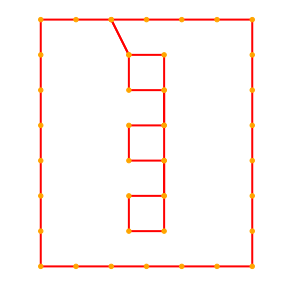

In [6]:
####################存储trueseed到row、col和allcoord中，并输出结果
f = open("Boundary.txt")
trueseed = [[], [], []]#trueseed表示当前边界，这里前两个维度和之前的seed一样，第三个维度记录的是该点在allcoord中的位置，方便对应
line = f.readline()
while line:
    line = line.strip("\n")
    line = line.split(" ")
    line_read = np.array(line)
    trueseed[0].append(float(line_read[0]))
    trueseed[1].append(float(line_read[1]))
    line = f.readline()
f.close()
number = -1
row = []
col = []
allcoord = [[], []]
for i in range(len(trueseed[0])):
    number += 1
    trueseed[2].append(number)
    row.append(number)
    col.append(number + 1)
    allcoord[0].append(trueseed[0][i])
    allcoord[1].append(trueseed[1][i])
col[len(col) - 1] = 0#首尾相连
plt.figure(figsize=(5, 5))
#plt.title("Seed Result")
plt.axis("equal")
plt.grid()
for i in range(len(row)):
    plt.plot([allcoord[0][row[i]], allcoord[0][col[i]]], [allcoord[1][row[i]], allcoord[1][col[i]]], linewidth = linesize, color = "red")
for i in range(len(allcoord[0])):
    plt.scatter(allcoord[0][i], allcoord[1][i], s = pointsize, color = "orange", zorder = 5)
#pl = plt.legend()
#plf = pl.get_frame()
#plf.set_alpha(1)
#plf.set_facecolor('none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("Boundary.eps", bbox_inches = 'tight', transparent = True)
plt.show()